In [28]:
!pip install trimesh
!pip install path
!pip install thop
!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
!unzip -q ModelNet10.zip;

--2023-08-28 10:40:28--  http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Resolving 3dvision.princeton.edu (3dvision.princeton.edu)... 128.112.136.67
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.67|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip [following]
--2023-08-28 10:40:29--  https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473402300 (451M) [application/zip]
Saving to: ‘ModelNet10.zip.1’

ModelNet10.zip.1    100%[===================>] 451.47M  12.4MB/s    in 38s     

2023-08-28 10:41:08 (11.8 MB/s) - ‘ModelNet10.zip.1’ saved [473402300/473402300]

replace ModelNet10/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/ModelNet10/._.DS_Store? [

In [29]:
import trimesh
from path import Path
import numpy as np
import math
import random
import os
import torch
from glob import glob
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import plotly.graph_objects as go
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from torchsummary import summary
from thop import profile
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
if torch.cuda.is_available():
  if_cuda=True
else:
  if_cuda=False
seed_value=0
np.random.seed(seed_value) # cpu vars
torch.manual_seed(seed_value) # cpu  vars
random.seed(seed_value) # Python
os.environ['PYTHONHASHSEED']=str(seed_value)
if if_cuda:
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value) # gpu vars
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [31]:
class SamplePoints:
    def randomSample(self):
        indexes = random.sample(range(self.points.shape[0]), self.npoint)
        return self.points[indexes]

    def farthestPointSample(self):
        N, D = self.points.shape
        xyz = self.points[:,:3]
        centroids = np.zeros((self.npoint,))
        distance = np.ones((N,)) * 1e10
        farthest = np.random.randint(0, N)
        for i in range(self.npoint):
            centroids[i] = farthest
            centroid = xyz[farthest, :]
            dist = np.sum((xyz - centroid) ** 2, -1)
            mask = dist < distance
            distance[mask] = dist[mask]
            farthest = np.argmax(distance, -1)
        points = self.points[centroids.astype(np.int32)]
        return points

    def normalize(self,spc):
        npc = spc - np.mean(spc, axis=0)
        npc /= np.max(np.linalg.norm(npc, axis=1))
        return npc

    def totensor(self,p):
        return torch.from_numpy(p)

    def RandomRotation(self,pc):
        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        rot_pointcloud = rot_matrix.dot(pc.T).T
        return  rot_pointcloud

    def RandomNoise(self,pc):
        noise = np.random.normal(0, 0.02, (pc.shape))
        npc = pc + noise
        return  npc

    def __init__(self,points,npoints=1024):
        self.points=points
        self.npoint=npoints

In [32]:

class ModelNet10Datset(Dataset):
    def __init__(self, root_dir, valid=False, folder="train"):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        pcd = trimesh.load(file)
        sampled_pc = trimesh.sample.sample_surface(pcd,5000)
        pc = sampled_pc[0]
        k=SamplePoints(pc)
        pc=k.farthestPointSample()
        pc=k.normalize(pc)
        if self.valid == False:
            pc=k.RandomRotation(pc)
            pc=k.RandomNoise(pc)
        pc=k.totensor(pc)
        return pc

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']

        pointcloud = self.__preproc__(pcd_path)

        return {'pointcloud': pointcloud, 'category': self.classes[category]}

In [33]:

class PointNet_vanilla(nn.Module):
    def __init__(self,k=3,classes=10):
        super().__init__()
        self.conv1 = nn.Conv1d(k,64,1)
        self.conv2 = nn.Conv1d(64,64,1)
        self.conv3 = nn.Conv1d(64,64,1)
        self.conv4 = nn.Conv1d(64,128,1)
        self.conv5 = nn.Conv1d(128,1024,1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(1024)
        self.fc1 = nn.Linear(1024, 516)
        self.fc2 = nn.Linear(516, 256)
        self.fc3 = nn.Linear(256, classes)

    def forward(self,input):
        input = F.relu(self.bn1(self.conv1(input)))
        input = F.relu(self.bn2(self.conv2(input)))
        input = F.relu(self.bn3(self.conv3(input)))
        input = F.relu(self.bn4(self.conv4(input)))
        input = F.relu(self.bn5(self.conv5(input)))
        input = F.adaptive_max_pool1d(input, 1).squeeze(-1)
        input=F.relu(self.fc1(input))
        input=F.relu(self.fc2(input))
        input=F.relu(self.fc3(input))
        return input


In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [35]:
pointnet=PointNet_vanilla()
pointnet.to(device)
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.0001)
summary(pointnet,(3,1024))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 1024]             256
       BatchNorm1d-2             [-1, 64, 1024]             128
            Conv1d-3             [-1, 64, 1024]           4,160
       BatchNorm1d-4             [-1, 64, 1024]             128
            Conv1d-5             [-1, 64, 1024]           4,160
       BatchNorm1d-6             [-1, 64, 1024]             128
            Conv1d-7            [-1, 128, 1024]           8,320
       BatchNorm1d-8            [-1, 128, 1024]             256
            Conv1d-9           [-1, 1024, 1024]         132,096
      BatchNorm1d-10           [-1, 1024, 1024]           2,048
           Linear-11                  [-1, 516]         528,900
           Linear-12                  [-1, 256]         132,352
           Linear-13                   [-1, 10]           2,570
Total params: 815,502
Trainable params:

In [44]:
input = torch.randn(32,3, 1024)
model=PointNet_vanilla()
macs, params = profile(model, inputs=(input, ))
macs

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


5035507712.0

In [23]:
path=Path("ModelNet10")
train_dataset = ModelNet10Datset(path)
valid_dataset = ModelNet10Datset(path, valid=True, folder='test')
classes = {i: cat for cat, i in train_dataset.classes.items()}
classes

{0: 'bathtub',
 1: 'bed',
 2: 'chair',
 3: 'desk',
 4: 'dresser',
 5: 'monitor',
 6: 'night_stand',
 7: 'sofa',
 8: 'table',
 9: 'toilet'}

In [24]:
print('Train dataset size: ', len(train_dataset))
print('Valid dataset size: ', len(valid_dataset))
print('Number of classes: ', len(train_dataset.classes))
print('Sample pointcloud shape: ', train_dataset[0]['pointcloud'].size())
print('Class: ',classes[train_dataset[0]['category']])

Train dataset size:  3991
Valid dataset size:  908
Number of classes:  10
Sample pointcloud shape:  torch.Size([1024, 3])
Class:  bathtub


In [25]:
batch_size=64
epochs=3
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,drop_last=False)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size,drop_last=False,shuffle=True)

In [26]:
for epoch in range(epochs):
    pointnet.train()
    running_loss = 0.0
    mean_correct=[]
    i=0
    for data in tqdm(train_loader,ncols= 100):
        inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
        optimizer.zero_grad()
        outputs= pointnet(inputs.transpose(1,2))

        loss =F.cross_entropy(outputs,labels)
        loss.backward()
        optimizer.step()

        pred_choice=outputs.data.max(1)[1]
        correct=pred_choice.eq(labels.data).cpu().sum()
        mean_correct.append(correct.item()/float(batch_size))
        running_loss += loss.item()
        i=i+1
        if i % 10 == 9:
          print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f mean accuracy: %f' %
            (epoch + 1, i + 1, len(train_loader), running_loss / 10, np.mean(mean_correct)))
          running_loss = 0.0

    pointnet.eval()
    correct = total = 0
    # validation
    with torch.no_grad():
        for data in tqdm(valid_loader):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            outputs = pointnet(inputs.transpose(1,2))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = 100. * correct / total
    print('Valid accuracy: %d %%' % val_acc)

    # save the model
    torch.save(pointnet.state_dict(), "save_"+str(epoch+1)+".pth")


 14%|█████████▏                                                      | 9/63 [02:36<14:58, 16.64s/it]

[Epoch: 1, Batch:   10 /   63], loss: 1.905 mean accuracy: 0.347222


 30%|███████████████████                                            | 19/63 [05:26<12:33, 17.13s/it]

[Epoch: 1, Batch:   20 /   63], loss: 1.883 mean accuracy: 0.391447


 46%|█████████████████████████████                                  | 29/63 [08:38<10:21, 18.26s/it]

[Epoch: 1, Batch:   30 /   63], loss: 1.669 mean accuracy: 0.427263


 62%|███████████████████████████████████████                        | 39/63 [11:56<07:49, 19.54s/it]

[Epoch: 1, Batch:   40 /   63], loss: 1.590 mean accuracy: 0.458333


 78%|█████████████████████████████████████████████████              | 49/63 [15:04<04:43, 20.26s/it]

[Epoch: 1, Batch:   50 /   63], loss: 1.342 mean accuracy: 0.487245


 94%|███████████████████████████████████████████████████████████    | 59/63 [18:55<01:20, 20.10s/it]

[Epoch: 1, Batch:   60 /   63], loss: 1.344 mean accuracy: 0.505561


100%|██████████| 15/15 [03:52<00:00, 15.53s/it]


Valid accuracy: 41 %


 14%|█████████▏                                                      | 9/63 [02:45<16:52, 18.75s/it]

[Epoch: 2, Batch:   10 /   63], loss: 1.075 mean accuracy: 0.619792


 30%|███████████████████                                            | 19/63 [05:31<11:56, 16.29s/it]

[Epoch: 2, Batch:   20 /   63], loss: 1.238 mean accuracy: 0.606908


 46%|█████████████████████████████                                  | 29/63 [08:16<09:09, 16.16s/it]

[Epoch: 2, Batch:   30 /   63], loss: 1.169 mean accuracy: 0.607759


 62%|███████████████████████████████████████                        | 39/63 [11:14<06:59, 17.48s/it]

[Epoch: 2, Batch:   40 /   63], loss: 1.160 mean accuracy: 0.601763


 78%|█████████████████████████████████████████████████              | 49/63 [14:07<03:59, 17.09s/it]

[Epoch: 2, Batch:   50 /   63], loss: 1.102 mean accuracy: 0.603635


 94%|███████████████████████████████████████████████████████████    | 59/63 [17:01<01:07, 16.79s/it]

[Epoch: 2, Batch:   60 /   63], loss: 1.116 mean accuracy: 0.603019


100%|██████████| 15/15 [03:48<00:00, 15.27s/it]


Valid accuracy: 41 %


 14%|█████████▏                                                      | 9/63 [02:42<16:30, 18.35s/it]

[Epoch: 3, Batch:   10 /   63], loss: 0.908 mean accuracy: 0.633681


 30%|███████████████████                                            | 19/63 [05:30<12:07, 16.53s/it]

[Epoch: 3, Batch:   20 /   63], loss: 1.041 mean accuracy: 0.620888


 46%|█████████████████████████████                                  | 29/63 [08:21<09:40, 17.07s/it]

[Epoch: 3, Batch:   30 /   63], loss: 1.013 mean accuracy: 0.623384


 62%|███████████████████████████████████████                        | 39/63 [11:10<06:53, 17.22s/it]

[Epoch: 3, Batch:   40 /   63], loss: 1.095 mean accuracy: 0.615385


 78%|█████████████████████████████████████████████████              | 49/63 [14:02<04:03, 17.43s/it]

[Epoch: 3, Batch:   50 /   63], loss: 0.991 mean accuracy: 0.617985


 94%|███████████████████████████████████████████████████████████    | 59/63 [16:43<01:05, 16.39s/it]

[Epoch: 3, Batch:   60 /   63], loss: 1.015 mean accuracy: 0.619439


100%|██████████| 15/15 [03:44<00:00, 14.99s/it]

Valid accuracy: 42 %


100%|██████████| 15/15 [04:15<00:00, 17.02s/it]


Valid accuracy: 42 %


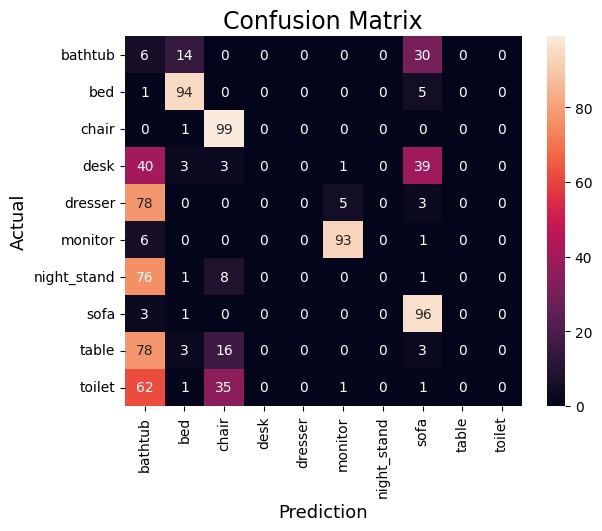

In [27]:
class PredictAndPlot:
    def __init__(self):
        self.classes = {i: cat for cat, i in valid_dataset.classes.items()}
        correct = total = 0
        pointnet = PointNet_vanilla()
        pointnet.load_state_dict(torch.load("save_"+str(epochs)+".pth",map_location=torch.device('cpu')))
        pointnet.eval()
        self.predicted = []
        self.actual = []
        with torch.no_grad():
            for data in tqdm(valid_loader):
                inputs, labels = data['pointcloud'].float(), data['category']
                outputs = pointnet(inputs.transpose(1,2))
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                self.predicted += list(predicted.numpy())
                self.actual += list(labels.numpy())
        val_acc = 100. * correct / total
        print('Valid accuracy: %d %%' % val_acc)
        self.plot()

    def plot(self):
        cm = confusion_matrix(self.actual,self.predicted)
        sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=self.classes.values(),
            yticklabels=self.classes.values())
        plt.xlabel('Prediction',fontsize=13)
        plt.ylabel('Actual',fontsize=13)
        plt.title('Confusion Matrix',fontsize=17)
        plt.show()

k=PredictAndPlot()